In [33]:
import pandas as pd
import json
import wikipediaapi
import pywikibot
import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
from typing import Dict, List, Any, Tuple, Optional
import time
import random
from urllib.parse import quote


In [40]:
DATA_PATH = "../../../data/movies_to_scrape_original.csv"
DATA_PATH2 = "../../../data/movies_all_scraped.csv"
pd.set_option("max_colwidth", None)

In [ ]:
df_movie = pd.read_csv(DATA_PATH)
df_movie_unscraped = df_movie.copy()
df_all_scraped = pd.read_csv(DATA_PATH2)

In [36]:
# Initialize a Wikipedia object using the wikipedia-api library, specifying the English language
wiki_object = wikipediaapi.Wikipedia('MovieSummaryExtractor', 'en')

In [56]:
class BoxOfficeBatchProcessor:
    def __init__(self, df: pd.DataFrame, movie_name_column: str = 'Movie_name', box_office_column: str = 'Movie_box_office_revenue'):
        self.df = df.copy()
        self.movie_name_column = movie_name_column
        self.box_office_column = box_office_column
        self.batch_size = 10
        self.site = pywikibot.Site('en', 'wikipedia')
        self.base_url = "https://en.wikipedia.org/wiki/"
        

    def has_film_section(self, film_name: str) -> bool:
        try:
            page_py = wiki_object.page(film_name)
            if not page_py.exists():
                return False
                
            for section_title in ["Plot", "Summary", "Synopsis"]:
                try:
                    section_plot = page_py.section_by_title(section_title)
                    if section_plot:  
                        return True
                except Exception as e:
                    print(f"Error checking section {section_title} for {film_name}: {str(e)}")
                    continue
            return False
            
        except Exception as e:
            print(f"Error in has_film_section for {film_name}: {str(e)}")
            return False

    def is_film_Wiki_page(self, title: str) -> tuple:
        try:
            page = pywikibot.Page(self.site, title)
            
            if page.exists() and page.isRedirectPage():
                page = page.getRedirectTarget()
                title = page.title()
                
            if self.has_film_section(title):
                return True, title
                
            film_title = f"{title} (film)"
            page = pywikibot.Page(self.site, film_title)
            
            if page.exists() and page.isRedirectPage():
                page = page.getRedirectTarget()
                film_title = page.title()
                
            if self.has_film_section(film_title):
                return True, film_title
                
            return False, title
            
        except Exception as e:
            print(f"Error in is_film_Wiki_page for {title}: {str(e)}")
            return False, title

    def clean_movie_title_for_url(self, title: str) -> str:
        """
        Properly encode movie title for Wikipedia URL.
        
        Args:
            title (str): Movie title
            
        Returns:
            str: Properly encoded title for URL
        """
        # Step 1: Replace spaces with underscores
        title = title.replace(' ', '_')
        
        # Step 2: Handle special characters that Wikipedia uses directly
        # These characters should appear in the URL without encoding
        safe_chars = {
            '(': '(',
            ')': ')',
            ',': ',',
            ':': ':',
            '.': '.',
            '!': '!',
            '-': '-',
            '&': '%26',  # Special case: ampersand needs encoding
        }
        
        # Step 3: Apply character replacements
        encoded = ''
        for char in title:
            if char in safe_chars:
                encoded += safe_chars[char]
            elif char.isalnum() or char == '_':
                encoded += char
            else:
                # Only encode other special characters
                encoded += quote(char)
        
        return encoded

    def get_box_office_from_wikipedia(self, title: str) -> str:
        if not isinstance(title, str) or title.strip() == '':
            return None
            
        validity, title = self.is_film_Wiki_page(title)
        
        if validity:
            # Change this part
            encoded_title = self.clean_movie_title_for_url(title)  # Use the new method
            url = f"{self.base_url}{encoded_title}"
            
            try:
                # Add this logging line
                print(f"Attempting to fetch: {url}")  # New line for debugging
                
                response = requests.get(url)
                response.raise_for_status()
                
                soup = BeautifulSoup(response.text, 'html.parser')
                infobox = soup.find('table', {'class': 'infobox'})
                if infobox is None:
                    # Add this logging line
                    print(f"No infobox found for {title}")  # New line
                    return None
                
                for row in infobox.find_all('tr'):
                    header = row.find('th', {'scope': 'row'})
                    if header and header.text.strip() in ['Box office', 'Revenue', 'Gross']:
                        box_office = row.find('td').text.strip()
                        return re.sub(r'\[\d+\]', '', box_office).strip()
                
                # Add this logging line
                print(f"No box office information found in infobox for {title}")  # New line
                
            except requests.RequestException as e:
                # Modify this error logging
                print(f"Request failed for {title}: {e}")
                print(f"Attempted URL: {url}")  # New line
            except Exception as e:
                print(f"Unexpected error for {title}: {e}")
                
        return None
    
    def fetch_box_office_batch(self, movie_batch: pd.DataFrame) -> List[Dict[str, Any]]:
        results = []
        for _, row in movie_batch.iterrows():
            try:
                movie_title = row[self.movie_name_column]
                current_box_office = row[self.box_office_column]
                
                if pd.isna(current_box_office):
                    try:
                        # Check if it's a valid Wikipedia film page
                        validity, movie_title = self.is_film_Wiki_page(movie_title)
                        if not validity:
                            results.append({
                                'index': row.name,
                                'box_office': None,
                                'movie_name': movie_title,
                                'error': 'InvalidWikiPage',
                                'error_detail': f"No valid Wikipedia film page found for {movie_title}"
                            })
                            continue
                            
                        box_office = self.get_box_office_from_wikipedia(movie_title)
                        if box_office is None:
                            results.append({
                                'index': row.name,
                                'box_office': None,
                                'movie_name': movie_title,
                                'error': 'NoBoxOfficeData',
                                'error_detail': f"No box office data found for {movie_title}"
                            })
                        else:
                            results.append({
                                'index': row.name,
                                'box_office': box_office,
                                'movie_name': movie_title,
                                'error': None,
                                'error_detail': None
                            })
                    except requests.RequestException as e:
                        results.append({
                            'index': row.name,
                            'box_office': None,
                            'movie_name': movie_title,
                            'error': 'RequestError',
                            'error_detail': str(e)
                        })
                    except pywikibot.exceptions.NoPage:
                        results.append({
                            'index': row.name,
                            'box_office': None,
                            'movie_name': movie_title,
                            'error': 'PageNotFound',
                            'error_detail': f"Wikipedia page not found for {movie_title}"
                        })
                    except BeautifulSoup.ParserError:
                        results.append({
                            'index': row.name,
                            'box_office': None,
                            'movie_name': movie_title,
                            'error': 'ParsingError',
                            'error_detail': f"Failed to parse HTML for {movie_title}"
                        })
                else:
                    results.append({
                        'index': row.name,
                        'box_office': current_box_office,
                        'movie_name': movie_title,
                        'error': None,
                        'error_detail': None
                    })
                
                time.sleep(1)
                
            except Exception as e:
                error_type = type(e).__name__
                results.append({
                    'index': row.name,
                    'box_office': None,
                    'movie_name': movie_title,
                    'error': 'UnexpectedError',
                    'error_detail': f"{error_type}: {str(e)}"
                })
                
        return results

    def process_in_batches(self, batch_size: int = None) -> pd.DataFrame:
        if batch_size:
            self.batch_size = batch_size
            
        mask = pd.isna(self.df[self.box_office_column])
        df_to_process = self.df[mask]
        
        total_movies = len(df_to_process)
        print(f"Processing {total_movies} movies in batches of {self.batch_size}...")
        
        batches = [df_to_process.iloc[i:i + self.batch_size] 
                  for i in range(0, total_movies, self.batch_size)]
        
        with ThreadPoolExecutor() as executor:
            all_results = []
            for batch_results in executor.map(self.fetch_box_office_batch, batches):
                all_results.extend(batch_results)
                processed = len(all_results)
                print(f"Progress: {processed}/{total_movies} movies processed "
                      f"({(processed/total_movies*100):.1f}%)")
        
        successful_fetches = 0
        for result in all_results:
            if result['box_office']:
                successful_fetches += 1
            self.df.loc[result['index'], self.box_office_column] = result['box_office']
            
        print(f"\nProcessing complete. Successfully fetched box office data for "
              f"{successful_fetches}/{total_movies} movies "
              f"({(successful_fetches/total_movies*100):.1f}%)")
        
        self._print_final_stats(all_results)
        return self.df

    def get_processing_stats(self) -> Dict[str, Any]:
        total_rows = len(self.df)
        successful_fetches = self.df[self.box_office_column].notna().sum()
        failed_fetches = self.df[self.box_office_column].isna().sum()
        
        return {
            'total_movies': total_rows,
            'successful_fetches': successful_fetches,
            'failed_fetches': failed_fetches,
            'success_rate': (successful_fetches / total_rows * 100)
        }
    def _print_final_stats(self, results: List[Dict[str, Any]]) -> None:
        total = len(results)
        successful = sum(1 for r in results if r['box_office'] is not None)
        failed = total - successful
        
        print("\nProcessing Summary:")
        print(f"Total movies processed: {total}")
        print(f"Successful fetches: {successful} ({(successful/total*100):.1f}%)")
        print(f"Failed fetches: {failed} ({(failed/total*100):.1f}%)")
        
        # Detailed error analysis
        error_categories = {
            'InvalidWikiPage': 0,
            'NoBoxOfficeData': 0,
            'RequestError': 0,
            'PageNotFound': 0,
            'ParsingError': 0,
            'UnexpectedError': 0
        }
        
        error_details = {
            'InvalidWikiPage': [],
            'NoBoxOfficeData': [],
            'RequestError': [],
            'PageNotFound': [],
            'ParsingError': [],
            'UnexpectedError': []
        }
        
        for result in results:
            if result['error']:
                error_categories[result['error']] += 1
                error_details[result['error']].append({
                    'movie': result['movie_name'],
                    'detail': result['error_detail']
                })
        
        if any(error_categories.values()):
            print("\nError Distribution:")
            for category, count in error_categories.items():
                if count > 0:
                    print(f"\n{category}: {count} occurrences ({(count/failed*100):.1f}% of failures)")
                    print("Sample of affected movies:")
                    for i, error in enumerate(error_details[category][:3], 1):  # Show up to 3 examples
                        print(f"  {i}. {error['movie']}: {error['detail']}")

In [57]:
processor = BoxOfficeBatchProcessor(df_movie)
updated_df = processor.process_in_batches(batch_size=200)
stats = processor.get_processing_stats()

Processing 1927 movies in batches of 200...
Error in is_film_Wiki_page for nan: argument of type 'float' is not iterable
Error in is_film_Wiki_page for nan: argument of type 'float' is not iterable
Attempting to fetch: https://en.wikipedia.org/wiki/Manam_Kothi_Paravai
Attempting to fetch: https://en.wikipedia.org/wiki/No_Entry_Pudhe_Dhoka_Aahey
No box office information found in infobox for Manam Kothi Paravai
No box office information found in infobox for No Entry Pudhe Dhoka Aahey
Attempting to fetch: https://en.wikipedia.org/wiki/Behind_the_Mask:_The_Rise_of_Leslie_Vernon
Attempting to fetch: https://en.wikipedia.org/wiki/The_Brooklyn_Brothers_Beat_the_Best
No box office information found in infobox for The Brooklyn Brothers Beat the Best
Attempting to fetch: https://en.wikipedia.org/wiki/West_of_the_Water_Tower
Error in is_film_Wiki_page for nan: argument of type 'float' is not iterable
Attempting to fetch: https://en.wikipedia.org/wiki/Outlaws_of_Love
Attempting to fetch: https://

  self.df.loc[result['index'], self.box_office_column] = result['box_office']



30.11: Successfully fetched box office data for 1074/6224 movies (17.3%) (50mins for 10 000)

With added URL encoding: Successfully fetched box office data for 1678/6224 movies (27.0%)(20mins)

For a sample of 2000 movies, we count 3min45s minutes of running time. Successfully fetched box office data for 318/993 movies (32.0%)

Processing complete. Successfully fetched box office data for 336/932 movies (36.1%)

In [ ]:
print(updated_df["Movie_box_office_revenue"].isna().sum())
print(df_all_scraped["Movie_box_office_revenue"].tail(2000).isna().sum())
print(updated_df["Movie_name"].isna().sum())
print(df_all_scraped["Movie_name"].tail(2000).isna().sum())

1759
1759
249
249


In [53]:
df_movie = updated_df
print("The percentage of missing values in the Box office revenue category before scraping is:")
print(df_movie_unscraped["Movie_box_office_revenue"].isna().sum())
print("The percent age of missing values in the Box office revenue category after scraping is:")
print(df_movie["Movie_box_office_revenue"].isna().sum())

The percentage of missing values in the Box office revenue category before scraping is:
932
The percent age of missing values in the Box office revenue category after scraping is:
604


In [31]:
df_movie.to_csv(DATA_PATH, index=False)

Processing Summary:
Total movies processed: 6224
Successful fetches: 1118 (18.0%)
Failed fetches: 5106 (82.0%)

Error Distribution:
- No box office information found: 1894 occurrences
- No valid film page found: 1539 occurrences
- Page not found (404): 1466 occurrences
- Invalid movie title: 180 occurrences
- No infobox found: 27 occurrences
Success rate: 48.9%

Error distribution:
- : 3776
- No box office information found: 1894
- No valid film page found: 1539
- Page not found (404): 1466
- Invalid movie title: 180
- No infobox found: 27


### Plot the results

Plot the percentage of missing values in the Box office revenue category, for a sample of 2000 values, before and after scraping

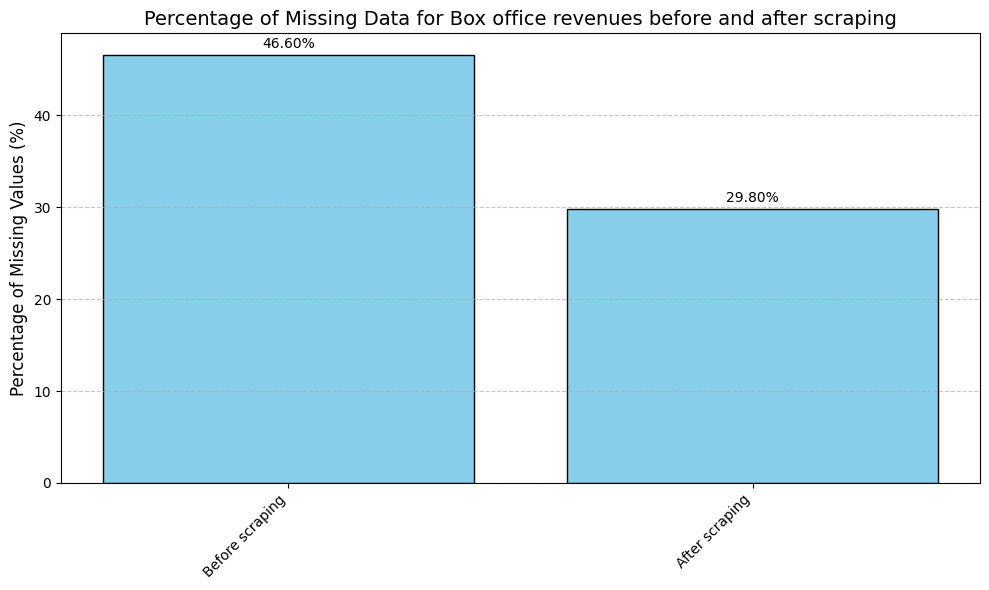

In [ ]:
# Calculate the percentage of missing values in the Box office revenue category, for a sample of 2000 values of the dataset
missing_values_before_scraping = df_movie_unscraped["Movie_box_office_revenue"].isna().sum() / len(df_movie_unscraped) * 100
missing_values_after_scraping = df_movie["Movie_box_office_revenue"].isna().sum() / len(df_movie) * 100

# Plot the filtered missing values as a bar chart
plt.figure(figsize=(10, 6))

plt.bar(['Before scraping', 'After scraping'], [missing_values_before_scraping, missing_values_after_scraping],color='skyblue', edgecolor='black')


plt.title('Percentage of Missing Data for Box office revenues before and after scraping', fontsize=14)
plt.ylabel('Percentage of Missing Values (%)', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the percentage value above each bar
for i, value in enumerate([missing_values_before_scraping, missing_values_after_scraping]):
    plt.text(i, value + 0.4, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()